# Requirements and initialisation

In [29]:
import cosima_cookbook as cc
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cm
from dask.distributed import Client

# Stop annoying warnings from xarray
import warnings
warnings.filterwarnings("ignore")

# Start local Dask cluster
client = Client(n_workers=4)

# Start COSIMA DB session
session = cc.database.create_session()

# Load data

In [30]:
# Experiment information
expt = "01deg_jra55v13_ryf9091"
start_time = "2060-01-01"
end_time = "2064-12-31"

In [31]:
# Load bathymetry
ht = cc.querying.getvar(expt, "ht", session, n=-1)

In [36]:
# Load ty_trans_rho
psi = cc.querying.getvar(expt, "ty_trans_rho", session, n=1)

# Create masks for Atlantic & Indo-Pacific Basins

In [32]:
# Create land mask - data array where 1 = ocean and 0 = land
# Used to delineate different ocean basins
land_mask = ~ht.isnull()

(-80.0, 90.0)

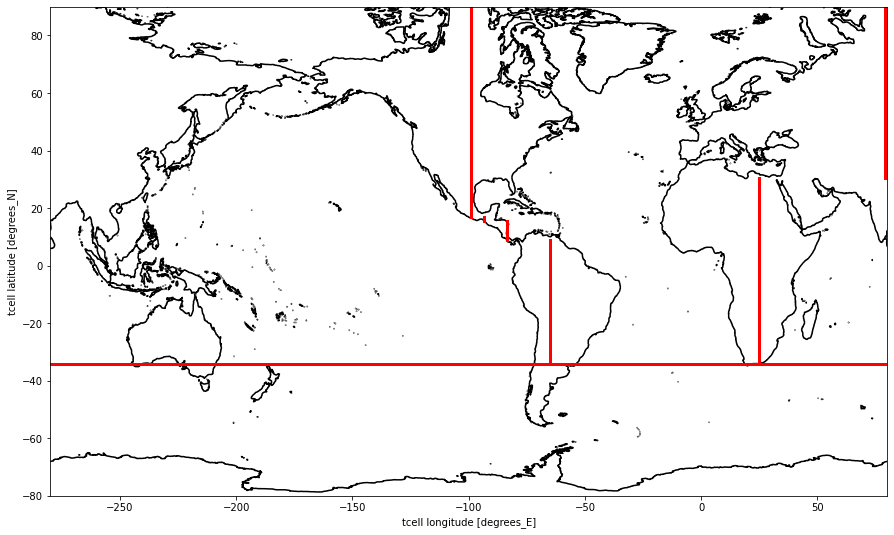

In [33]:
# Plot set of meridians separating the Atlantic basin from the Indo-Pacific basins
fig = plt.figure(2,(15,9))
ax = plt.subplot()
land_mask.plot.contour(levels=[0.5], colors="k")
ax.plot([-280, 80], [-34, -34], "r", linewidth=3)
ax.plot([-65, -65], [-34, 9], "r", linewidth=3)
ax.plot([-83.7, -83.7], [9, 15.5], "r", linewidth=3)
ax.plot([-93.3, -93.3], [15.5, 17], "r", linewidth=3)
ax.plot([-99, -99], [17, 90], "r", linewidth=3)
ax.plot([25, 25], [-34, 30.5], "r", linewidth=3)
ax.plot([79, 79], [30.5, 90], "r", linewidth=3)
ax.set_xlim([-280,80])
ax.set_ylim([-80,90])

In [34]:
# Create masks based on these regions
south_map = (land_mask.where(land_mask.yt_ocean < -34)).fillna(0)

indo_map1 = (
    land_mask
    .where(land_mask.yt_ocean < 9)
    .where(land_mask.yt_ocean > -34)
    .where(land_mask.xt_ocean >-280)
    .where(land_mask.xt_ocean<-65)
).fillna(0)

indo_map2 = (
    land_mask
    .where(land_mask.yt_ocean < 15)
    .where(land_mask.yt_ocean > 9)
    .where(land_mask.xt_ocean >-280)
    .where(land_mask.xt_ocean<-83.7)
).fillna(0)

indo_map3 = (
    land_mask
    .where(land_mask.yt_ocean < 17)
    .where(land_mask.yt_ocean > 15)
    .where(land_mask.xt_ocean >-280)
    .where(land_mask.xt_ocean<-93.3)
).fillna(0)

indo_map4 = (
    land_mask
    .where(land_mask.yt_ocean < 85)
    .where(land_mask.yt_ocean > 17)
    .where(land_mask.xt_ocean >-280)
    .where(land_mask.xt_ocean<-99)
).fillna(0)

indo_map5 = (
    land_mask
    .where(land_mask.yt_ocean < 30.5)
    .where(land_mask.yt_ocean > -34)
    .where(land_mask.xt_ocean >25)
    .where(land_mask.xt_ocean<80)
).fillna(0)

indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
indo_sector_mask = indo_sector_map.where(indo_sector_map>0)

atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
atlantic_sector_map = atlantic_sector_map + south_map
atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map>0)

Text(0.5, 1.0, 'Indo-Pacific + Southern Ocean Mask')

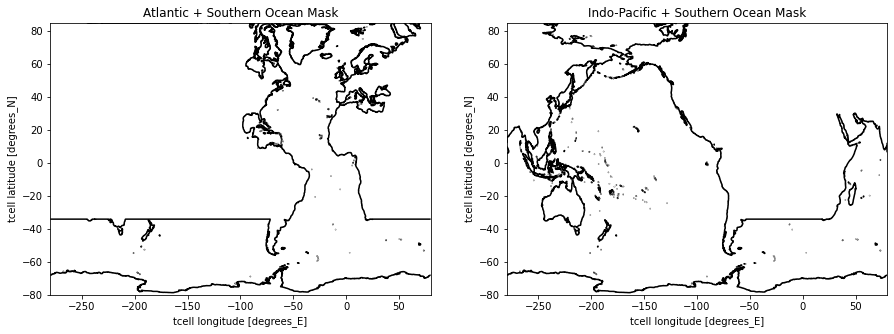

In [35]:
# Plot masks
fig, ax=plt.subplots(1,2, figsize=(15,5))

atlantic_sector_map.plot.contour(ax=ax[0],levels=[0.5],colors='k')
ax[0].set_xlim([-280,80])
ax[0].set_ylim([-80,85])
ax[0].set_title('Atlantic + Southern Ocean Mask')

indo_sector_map.plot.contour(ax=ax[1],levels=[0.5],colors='k')
ax[1].set_xlim([-280,80])
ax[1].set_ylim([-80,85])
ax[1].set_title('Indo-Pacific + Southern Ocean Mask')

# Convert mask coordinates

In [37]:
# Convert mask coordinates to match ty_trans_rho

# Mask is defined on (yt_ocean, xt_ocean)
# ty_trans_rho uses (yu_ocean, xt_ocean)
# So we need to convert our mask to yu_ocean

# Load a single frame of ty_trans_rho and replace the mask yt_ocean axis with yu_ocean
atlantic_sector_mask.coords["xt_ocean"] = psi.grid_xt_ocean.values
atlantic_sector_mask.coords["yt_ocean"] = psi.grid_yu_ocean.values
atlantic_sector_mask = atlantic_sector_mask.rename({
    "xt_ocean": "grid_xt_ocean",
    "yt_ocean": "grid_yu_ocean",
})

indo_sector_mask.coords["xt_ocean"] = psi.grid_xt_ocean.values
indo_sector_mask.coords["yt_ocean"] = psi.grid_yu_ocean.values
indo_sector_mask = indo_sector_mask.rename({
    "xt_ocean": "grid_xt_ocean",
    "yt_ocean": "grid_yu_ocean",
})

# Compute basin MOC

## Define MOC calculation function

In [45]:
def compute_basin_psi_rho(
    expt,
    session,
    basin_mask,
    nbound=None,
    start_time=None,
    end_time=None,
):
    """
    " Computes the time-averaged overturning circulation given an experiment and basin mask
    """
    
    rho = 1025 # mean density of sea-water in kg/m^3

    varlist = cc.querying.get_variables(session, expt)
    
    if varlist["name"].str.contains("ty_trans_rho_gm").any():
        gm = True
        print("GM is true")
        psi_gm = cc.querying.getvar(
            expt,
            "ty_trans_rho_gm",
            session,
            n=nbound,
            start_time=start_time,
            end_time=end_time,
        )
        psi_gm = psi_gm.sum("grid_xt_ocean")
        psi_gm = psi_gm/(1e6*rho)
    else:
        gm = False
        print("GM is false")

    psi = cc.querying.getvar(
        expt,
        "ty_trans_rho",
        session,
        n=nbound,
        start_time=start_time,
        end_time=end_time,
    )
    psi = psi/(1e6*rho) # converts kg/s to Sv
    psi = (psi*basin_mask).sum("grid_xt_ocean").cumsum("potrho").mean(dim="time").load()
    
    if gm:
        psi = psi + psi_gm.mean("time")

    return psi

## Compute Atlantic MOC

In [41]:
atlantic_psi = compute_basin_psi_rho(
    expt,
    session,
    atlantic_sector_mask,
    start_time=start_time,
    end_time=end_time,
)

GM is false


## Compute Indo-Pacific MOC

In [43]:
indopacific_psi = compute_basin_psi_rho(
    expt,
    session,
    indo_sector_mask,
    start_time=start_time,
    end_time=end_time,
)

GM is false


# Plot

Text(0.5, 0, 'Sv')

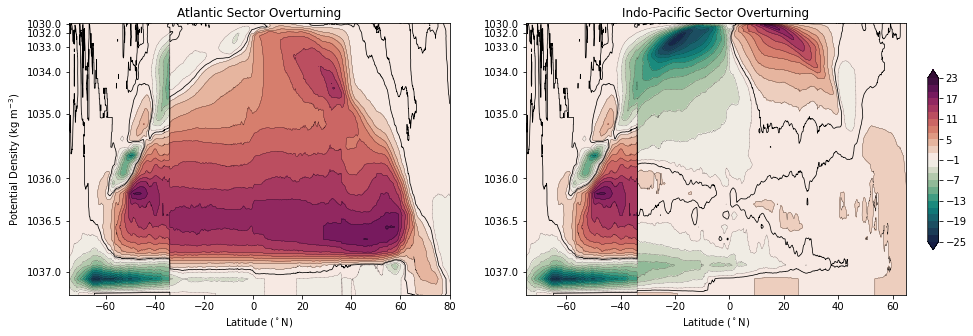

In [44]:
levels = np.arange(-25, 25, 2)
yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
scaling_factor = 4  # A power to set the stretching of the y-axis

fig, ax = plt.subplots(1,2, figsize=(15, 5))

# Plot Atlantic Sector
p1 = ax[0].contourf(
    atlantic_psi.grid_yu_ocean,
    (atlantic_psi.potrho - 1028)**scaling_factor,
    atlantic_psi,
    cmap=cm.cm.curl,
    levels=levels,
    extend="both",
)
ax[0].contour(
    atlantic_psi.grid_yu_ocean,
    (atlantic_psi.potrho - 1028)**scaling_factor,
    atlantic_psi,
    levels=levels,
    colors="k",
    linewidths=0.25,
)
ax[0].contour(
    atlantic_psi.grid_yu_ocean,
    (atlantic_psi.potrho - 1028)**scaling_factor,
    atlantic_psi,
    levels=[0.0,],
    colors="k",
    linewidths=0.75,
)
ax[0].set_yticks((yticks - 1028)**scaling_factor)
ax[0].set_yticklabels(yticks)
ax[0].set_ylim([0.5**scaling_factor, 9.2**scaling_factor])
ax[0].invert_yaxis()
ax[0].set_ylabel("Potential Density (kg m$^{-3}$)")
ax[0].set_xlabel("Latitude ($^\circ$N)")
ax[0].set_xlim([-75, 80])
ax[0].set_title("Atlantic Sector Overturning")


# Plot Indo-Pacific Sector
p1 = ax[1].contourf(
    indopacific_psi.grid_yu_ocean,
    (indopacific_psi.potrho - 1028)**scaling_factor,
    indopacific_psi,
    cmap=cm.cm.curl,
    levels=levels,
    extend="both",
)
ax[1].contour(
    indopacific_psi.grid_yu_ocean,
    (indopacific_psi.potrho - 1028)**scaling_factor,
    indopacific_psi,
    levels=levels,
    colors="k",
    linewidths=0.25,
)
ax[1].contour(
    indopacific_psi.grid_yu_ocean,
    (indopacific_psi.potrho - 1028)**scaling_factor,
    indopacific_psi,
    levels=[0.0,],
    colors="k",
    linewidths=0.75,
)
ax[1].set_yticks((yticks - 1028)**scaling_factor)
ax[1].set_yticklabels(yticks)
ax[1].set_ylim([0.5**scaling_factor, 9.2**scaling_factor])
ax[1].invert_yaxis()
ax[1].set_xlabel("Latitude ($^\circ$N)")
ax[1].set_xlim([-75,65])
ax[1].set_title("Indo-Pacific Sector Overturning");

# Add colorbar
cax = plt.axes([0.92, 0.25, 0.01, 0.5])
cb=plt.colorbar(p1, cax=cax, orientation="vertical")
cb.ax.set_xlabel("Sv")